**In this notebook:** 
    
    - we compute the proportional contribution to R0, using the definition of cumulative elasticities (see paper by Angeli et al here https://www.sciencedirect.com/science/article/pii/S002251932400002X)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import cm
import math
import random

import geopandas as gp 
from shapely.geometry import Point, LineString

import datetime as dt

import time

import scipy.stats as st

import seaborn as sns

from scipy.integrate import odeint
from numpy import linalg as LA

In [27]:
plt.rcParams['savefig.transparent']=False
plt.rcParams['savefig.facecolor']='white'

# read population data

In [2]:
# # read population data

data_pop_grouped = pd.read_csv("./../data/pop_size_by_age_SEP_edu.csv")

dict_pop_full = dict(zip(data_pop_grouped[['age_group',
                           'sep_level', 'edu_level']].apply(lambda x:
                                               x[0]+", "+x[1]+", "+x[2], axis=1).values,
                   data_pop_grouped['population']))
                   
pop_age = data_pop_grouped.groupby('age_group')['population'].sum()
pop_age = dict(zip(pop_age.index, pop_age.values))

distrib_pop = data_pop_grouped.groupby('age_group')['population'].sum()/data_pop_grouped['population'].sum()
distrib_pop = dict(zip(distrib_pop.index, distrib_pop.values))

# intermediate contact matrix

In [3]:
intermediate_matrix_rec = pd.read_csv("./../output/matrices/intermediate_matrix_rec.csv", index_col = 0)
intermediate_matrix_rec = intermediate_matrix_rec.fillna(0)

# functions to generate expanded contact matrix

In [4]:
def diag_block_children(age, q1_sep):

    #age = '0-14'

    tag_11 = ', low SEP, low edu'
    tag_12 = ', low SEP, high edu'
    tag_21 = ', high SEP, low edu'
    tag_22 = ', high SEP, high edu'

    # 16 unknowns
    # 4 conditions on the sum per row
    # 6 conditions on the reciprocity
    # 4 conditions on the assortativity on the diagonal
    # 1 condition on the assortativity in the edu dimension
    # 1 condition on the assortativity in the sep dimension

    a = np.array([[1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  #[0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.], ## sum
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.], ## sum
                  [0., 0., 1., 0.,  
                   0., 0., 0., 0.,  
                   -1., 0., 0., 0.,  
                   0., 0., 0., 0.], ## reciprocity
                  #[1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity 1st row
                  ###[0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity 2nd row
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.], ## assortativity 3rd row
                  ###[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.], ## assortativity 4th row
                  [1., 1., 0., 0.,  
                   1., 1., 0., 0.,  
                   0., 0., 0., 0.,  
                   0., 0., 0., 0.], ## assortativity sep dimension
                   #### null values
                  [0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.],
                 ])## assortativity
    b = np.array([intermediate_matrix_rec.loc[age+tag_11][age]*dict_pop_full[age+tag_11], 
                  #intermediate_matrix_rec.iloc[0:4][age].iloc[1],
                  intermediate_matrix_rec.loc[age+tag_21][age]*dict_pop_full[age+tag_21],
                  #intermediate_matrix_rec.iloc[0:4][age].iloc[3],
                  0., #0., 0., 0., 0., 0., 
                  #q111*intermediate_matrix_rec.iloc[0:4][age].iloc[0],
                  #q112*intermediate_matrix_rec.iloc[0:4][age].iloc[1],
                  #q121*intermediate_matrix_rec.iloc[0:4][age].iloc[2],
                  #q122*intermediate_matrix_rec.iloc[0:4][age].iloc[3],
                  q1_sep*(dict_pop_full[age+tag_11]*intermediate_matrix_rec.loc[age+tag_11][age]+dict_pop_full[age+tag_12]*intermediate_matrix_rec.loc[age+tag_12][age]),
                  #q1_edu*(dict_pop_full[age+tag_11]*intermediate_matrix_rec.iloc[0:4][age].iloc[0]+dict_pop_full[age+tag_21]*intermediate_matrix_rec.iloc[0:4][age].iloc[2])
                  ### null values
                  0., 0., 
                  0., 0., 0., 0., 
                  0., 0.,
                  0., 0., 0., 0.])

    x = np.linalg.solve(a, b)
    
    return x

In [5]:
def diag_block_age(age, q11, q12, q21, q22, q_sep, q_edu):

    #age = '15-24'

    tag_11 = ', low SEP, low edu'
    tag_12 = ', low SEP, high edu'
    tag_21 = ', high SEP, low edu'
    tag_22 = ', high SEP, high edu'

    # 16 unknowns
    # 4 conditions on the sum per row
    # 6 conditions on the reciprocity
    # 4 conditions on the assortativity on the diagonal
    # 1 condition on the assortativity in the edu dimension
    # 1 condition on the assortativity in the sep dimension

    a = np.array([[1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.], ## sum
                  [0., 1., 0., 0.,
                   -1., 0., 0., 0.,
                   0., 0., 0., 0.,
                   0., 0., 0., 0.], ## reciprocity
                  [0., 0., 1., 0.,
                   0., 0., 0., 0.,
                   -1., 0., 0., 0.,
                   0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 1.,
                   0., 0., 0., 0.,
                   0., 0., 0., 0.,
                   -1., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,
                   0., 0., 1., 0.,
                   0., -1., 0., 0.,
                   0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,
                   0., 0., 0., 1.,
                   0., 0., 0., 0.,
                   0., -1., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,
                   0., 0., 0., 0.,
                   0., 0., 0., 1.,
                   0., 0., -1., 0.], ## reciprocity
                  [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity 1st row
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity 2nd row
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.], ## assortativity 3rd row
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.], ## assortativity 4th row
                  [1., 1., 0., 0.,
                   1., 1., 0., 0.,
                   0., 0., 0., 0.,
                   0., 0., 0., 0.], ## assortativity sep dimension
                  [1., 0., 1., 0.,
                   0., 0., 0., 0.,
                   1., 0., 1., 0.,
                   0., 0., 0., 0.], ## assortativity edu dimension


                 ])## assortativity
    b = np.array([intermediate_matrix_rec.loc[age+tag_11][age]*dict_pop_full[age+tag_11],
                  intermediate_matrix_rec.loc[age+tag_12][age]*dict_pop_full[age+tag_12],
                  intermediate_matrix_rec.loc[age+tag_21][age]*dict_pop_full[age+tag_21],
                  intermediate_matrix_rec.loc[age+tag_22][age]*dict_pop_full[age+tag_22],
                  0., 0., 0., 0., 0., 0.,
                  q11*intermediate_matrix_rec.loc[age+tag_11][age]*dict_pop_full[age+tag_11],
                  q12*intermediate_matrix_rec.loc[age+tag_12][age]*dict_pop_full[age+tag_12],
                  q21*intermediate_matrix_rec.loc[age+tag_21][age]*dict_pop_full[age+tag_21],
                  q22*intermediate_matrix_rec.loc[age+tag_22][age]*dict_pop_full[age+tag_22],
                  q_sep*(dict_pop_full[age+tag_11]*intermediate_matrix_rec.loc[age+tag_11][age]+dict_pop_full[age+tag_12]*intermediate_matrix_rec.loc[age+tag_12][age]),
                  q_edu*(dict_pop_full[age+tag_11]*intermediate_matrix_rec.loc[age+tag_11][age]+dict_pop_full[age+tag_21]*intermediate_matrix_rec.loc[age+tag_21][age])])

    x = np.linalg.solve(a, b)
    
    return x

In [6]:
def offdiag_block_children(age_i, age_j, q11, q21, q12_sep):

    #age_i = '0-14'
    #age_j = '15-24'

    tag_11 = ', low SEP, low edu'
    tag_12 = ', low SEP, high edu'
    tag_21 = ', high SEP, low edu'
    tag_22 = ', high SEP, high edu'

    a = np.array([[1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  #[0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.], ## sum

                  [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  #[0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal

                  #[0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy
                  #[0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy


                [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   -1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  -1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  -1., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  -1., 0., 0., 0.], ## reciprocity

                #[0., 0., 0., 0.,  dict_pop_full[age_i+tag_12], 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                #   0., -dict_pop_full[age_j+tag_11], 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., dict_pop_full[age_i+tag_12], 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                #   0., 0., 0., 0.,  0., -dict_pop_full[age_j+tag_12], 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., dict_pop_full[age_i+tag_12], 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                #   0., 0., 0., 0.,  0., 0., 0., 0.,  0., -dict_pop_full[age_j+tag_21], 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., 0., dict_pop_full[age_i+tag_12],  0., 0., 0., 0.,  0., 0., 0., 0.,
                #   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., -dict_pop_full[age_j+tag_22], 0., 0.], ## reciprocity

                [0., 0., 0., 0.,  0., 0., 0., 0., 1., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., -1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., -1.,  0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., -1., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., dict_pop_full[age_i+tag_21],  0., 0., 0., 0.,
                #   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., -dict_pop_full[age_j+tag_22], 0.], ## reciprocity

                #  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  dict_pop_full[age_i+tag_22], 0., 0., 0.,
                #   0., 0., 0., -dict_pop_full[age_j+tag_11],  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., dict_pop_full[age_i+tag_22], 0., 0.,
                #   0., 0., 0., 0.,  0., 0., 0., -dict_pop_full[age_j+tag_12],  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., dict_pop_full[age_i+tag_22], 0.,
                #   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., -dict_pop_full[age_j+tag_21],  0., 0., 0., 0.], ## reciprocity
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., dict_pop_full[age_i+tag_22],
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., -dict_pop_full[age_j+tag_22]], ## reciprocity

                 [1., 1., 0., 0.,
                   1., 1., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity sep dimension
                 # [dict_pop_full[age_i+tag_11], 0., dict_pop_full[age_i+tag_11], 0.,
                 #  0., 0., 0., 0.,
                 #  dict_pop_full[age_i+tag_21], 0., dict_pop_full[age_i+tag_21], 0.,
                 #  0., 0., 0., 0.,
                 #  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity edu dimension
                 ### null values
                  [0., 0., 0., 0.,  1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.],
               ],
                )

    b = np.array([intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  #intermediate_matrix_rec.iloc[0:4][age_j].iloc[1],
                  intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  #intermediate_matrix_rec.iloc[0:4][age_j].iloc[3],
                  intermediate_matrix_rec.loc[age_j+tag_11][age_i]*dict_pop_full[age_j+tag_11],
                  intermediate_matrix_rec.loc[age_j+tag_12][age_i]*dict_pop_full[age_j+tag_12],
                  intermediate_matrix_rec.loc[age_j+tag_21][age_i]*dict_pop_full[age_j+tag_21],
                  intermediate_matrix_rec.loc[age_j+tag_22][age_i]*dict_pop_full[age_j+tag_22],
                  q11*intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  #q12*intermediate_matrix_rec.iloc[0:4][age_j].iloc[1],
                  q21*intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  #q22*intermediate_matrix_rec.iloc[0:4][age_j].iloc[3],
                  #r1*(1.-q11)*intermediate_matrix_rec.iloc[0:4][age_j].iloc[0],
                  #r2*(1.-q12)*intermediate_matrix_rec.iloc[0:4][age_j].iloc[1],
                  #r3*(1.-q21)*intermediate_matrix_rec.iloc[0:4][age_j].iloc[2],
                  0., 0., 0., 0.,
                  #0., 0., 0., 0.,
                  0., 0., 0., #0.,
                  #0., 0., 0., #0.,
                  q12_sep*(dict_pop_full[age_i+tag_11]*intermediate_matrix_rec.loc[age_i+tag_11][age_j]+dict_pop_full[age_i+tag_12]*intermediate_matrix_rec.loc[age_i+tag_12][age_j]),
                  #q12_edu*(dict_pop_full[age_i+tag_11]*intermediate_matrix_rec.iloc[0:4][age_j].iloc[0]+dict_pop_full[age_i+tag_21]*intermediate_matrix_rec.iloc[0:4][age_j].iloc[2]),
                  ### null values (16)
                  0., 0., 0., 0.,
                  0., 0., 0., 0.,
                  0., 0.,
                  0., 0.,
                  0., 0.,
                  0., 0.,
                 ])

    x = np.linalg.solve(a, b)
    
    return x

In [7]:
def offdiag_block_age(age_i, age_j, q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu):

    #age_i = '15-24'
    #age_j = '25-64'

    tag_11 = ', low SEP, low edu'
    tag_12 = ', low SEP, high edu'
    tag_21 = ', high SEP, low edu'
    tag_22 = ', high SEP, high edu'

    a = np.array([[1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.], ## sum

                  [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal

                 [0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy
                  [0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy


                [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   -1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  -1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  -1., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  -1., 0., 0., 0.], ## reciprocity

                [0., 0., 0., 0.,  1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., -1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., -1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., -1., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., -1., 0., 0.], ## reciprocity

                [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., -1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., -1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., -1., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., -1., 0.], ## reciprocity

                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 0., 0., 0.,
                   0., 0., 0., -1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., -1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., -1.,  0., 0., 0., 0.], ## reciprocity
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., dict_pop_full[age_i+tag_22],
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., -dict_pop_full[age_j+tag_22]], ## reciprocity

                 [1., 1., 0., 0.,
                   1., 1., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity sep dimension
                  [1., 0., 1., 0.,
                   0., 0., 0., 0.,
                   1., 0., 1., 0.,
                   0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity edu dimension
                  ])

    b = np.array([intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  intermediate_matrix_rec.loc[age_i+tag_12][age_j]*dict_pop_full[age_i+tag_12],
                  intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  intermediate_matrix_rec.loc[age_i+tag_22][age_j]*dict_pop_full[age_i+tag_22],
                  intermediate_matrix_rec.loc[age_j+tag_11][age_i]*dict_pop_full[age_j+tag_11],
                  intermediate_matrix_rec.loc[age_j+tag_12][age_i]*dict_pop_full[age_j+tag_12],
                  intermediate_matrix_rec.loc[age_j+tag_21][age_i]*dict_pop_full[age_j+tag_21],
                  intermediate_matrix_rec.loc[age_j+tag_22][age_i]*dict_pop_full[age_j+tag_22],
                  q11*intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  q12*intermediate_matrix_rec.loc[age_i+tag_12][age_j]*dict_pop_full[age_i+tag_12],
                  q21*intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  q22*intermediate_matrix_rec.loc[age_i+tag_22][age_j]*dict_pop_full[age_i+tag_22],
                  r1*(1.-q11)*intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  r2*(1.-q12)*intermediate_matrix_rec.loc[age_i+tag_12][age_j]*dict_pop_full[age_i+tag_12],
                  r3*(1.-q21)*intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  0., 0., 0., 0.,
                  0., 0., 0., 0.,
                  0., 0., 0., 0.,
                  0., 0., 0., #0.,
                  q_sep*(dict_pop_full[age_i+tag_11]*intermediate_matrix_rec.loc[age_i+tag_11][age_j]+dict_pop_full[age_i+tag_12]*intermediate_matrix_rec.loc[age_i+tag_12][age_j]),
                  q_edu*(dict_pop_full[age_i+tag_11]*intermediate_matrix_rec.loc[age_i+tag_11][age_j]+dict_pop_full[age_i+tag_21]*intermediate_matrix_rec.loc[age_i+tag_21][age_j]),
                 ])

    x = np.linalg.solve(a, b)
    
    return x

In [8]:
matrix_features = pd.read_csv("./../output/matrices/10000_matrices_characteristics.csv")
params = pd.read_csv("./../output/matrices/10000_sampled_combinations.csv")

In [9]:
for h,q in enumerate(['q11', 'q12', 'q21', 'q22', 'q_sep', 'q_edu']):
    params['block1_{}'.format(q)] = params['block1'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])

    params['block2_{}'.format(q)] = params['block2'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])

    params['block3_{}'.format(q)] = params['block3'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])
    
for h,q in enumerate(['q11', 'q12', 'q21', 'q22', 'r1', 'r2', 'r3', 'q_sep', 'q_edu']):
    params['block12_{}'.format(q)] = params['block12'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])
    
    params['block13_{}'.format(q)] = params['block13'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])
    
    params['block23_{}'.format(q)] = params['block23'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])
    
for h,q in enumerate(['q_sep']):
    params['block0_{}'.format(q)] = params['block0'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h]) 
    
    
for h,q in enumerate(['q11', 'q21', 'q_sep']):
    params['block01_{}'.format(q)] = params['block01'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h]) 
    
    params['block02_{}'.format(q)] = params['block02'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h]) 

    params['block03_{}'.format(q)] = params['block03'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h]) 

In [10]:
def generate_matrix(combination):
    
    c = combination

    ## diagonal block 1
    q11, q12, q21, q22, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block1_' in col]].values
    x1 = diag_block_age('15-24', q11, q12, q21, q22, q_sep, q_edu)

    ## diagonal block 2
    q11, q12, q21, q22, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block2_' in col]].values
    x2 = diag_block_age('25-64', q11, q12, q21, q22, q_sep, q_edu)

    ## diagonal block 3
    q11, q12, q21, q22, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block3_' in col]].values
    x3 = diag_block_age('65+', q11, q12, q21, q22, q_sep, q_edu)

    ## block 12
    q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block12_' in col]].values
    x12 = offdiag_block_age('15-24', '25-64', q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu)

    ## block 13
    q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block13_' in col]].values
    x13 = offdiag_block_age('15-24', '65+', q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu)

    ## block 23
    q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block23_' in col]].values
    x23 = offdiag_block_age('25-64', '65+', q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu)
    
    ## diagonal block 0
    par = params.iloc[c][[col for col in params.columns if 'block0_' in col]].values
    q_sep = par[0]
    x0 = diag_block_children('0-14', q_sep)        

    ## block 01
    par = params.iloc[c][[col for col in params.columns if 'block01_' in col]].values
    q11, q21, q_sep = par
    x01 = offdiag_block_children('0-14', '15-24', q11, q21, q_sep)

    ## block 02
    par = params.iloc[c][[col for col in params.columns if 'block02_' in col]].values
    q11, q21, q_sep = par
    x02 = offdiag_block_children('0-14', '25-64',q11, q21, q_sep)

    ## block 0
    par = params.iloc[c][[col for col in params.columns if 'block03_' in col]].values
    q11, q21, q_sep = par
    x03 = offdiag_block_children('0-14', '65+',q11, q21, q_sep)

    matrix_expanded_positive = np.zeros((16,16))

    matrix_expanded_positive[0:4,0:4] = x0.reshape(4,4)
    matrix_expanded_positive[4:8,4:8] = x1.reshape(4,4)
    matrix_expanded_positive[8:12,8:12] = x2.reshape(4,4)
    matrix_expanded_positive[12:16,12:16] = x3.reshape(4,4)

    matrix_expanded_positive[0:4,4:8] = x01.reshape(8,4)[:4]
    matrix_expanded_positive[4:8,0:4] = x01.reshape(8,4)[4:]

    matrix_expanded_positive[0:4,8:12] = x02.reshape(8,4)[:4]
    matrix_expanded_positive[8:12,0:4] = x02.reshape(8,4)[4:]

    matrix_expanded_positive[0:4,12:16] = x03.reshape(8,4)[:4]
    matrix_expanded_positive[12:16,0:4] = x03.reshape(8,4)[4:]

    matrix_expanded_positive[4:8,8:12] = x12.reshape(8,4)[:4]
    matrix_expanded_positive[8:12,4:8] = x12.reshape(8,4)[4:]

    matrix_expanded_positive[4:8,12:16] = x13.reshape(8,4)[:4]
    matrix_expanded_positive[12:16,4:8] = x13.reshape(8,4)[4:]

    matrix_expanded_positive[8:12,12:16] = x23.reshape(8,4)[:4]
    matrix_expanded_positive[12:16,8:12] = x23.reshape(8,4)[4:]

    matrix_expanded_positive = pd.DataFrame(matrix_expanded_positive)
    matrix_expanded_positive.index = intermediate_matrix_rec.index
    matrix_expanded_positive.columns = intermediate_matrix_rec.index

    matrix_expanded = matrix_expanded_positive.copy()
    
    df = matrix_expanded.values  # Convert DataFrame to NumPy array
    
    if np.allclose(df, df.T, atol=1e-8)==False: ## check symmetry of the matrix
        sys.exit()
        
    else:    
        ## this is the symmetric matrix with the total number of contacts between two groups 
        ## T_ij = M_ij*N_i = M_ji*N_j = T_ji 

        ## to compute the contact matrix of the number of contacts per participant, dived each row by the size of the 
        ## M_ij = T_ij/N_i
        
        for g in matrix_expanded.columns:
            if dict_pop_full[g]!= 0.:
                matrix_expanded.loc[g] = matrix_expanded.loc[g]/dict_pop_full[g]
            else:
                matrix_expanded.loc[g] = np.nan
        
        for g in matrix_expanded.columns:
            if dict_pop_full[g]== 0.:
                matrix_expanded[g] = np.nan
                
        matrix_expanded = matrix_expanded.dropna(how='all', axis = 0)
        matrix_expanded = matrix_expanded.dropna(how='all', axis = 1)
    
        return matrix_expanded

# functions to compute next generation matrix

In [11]:
def aggregate_matrix(M):
    avg = 0
    for i in M.index:
        avg += sum(M.loc[i])*dict_pop_full[i]/sum([dict_pop_full[j] for j in dict_pop_full.keys()])
    return avg

def compute_next_gen_matrix_SIR(M):
    
    ### SIR
    F = np.zeros((14, 14))
    for i,i_tag in enumerate(M.index):
        for j,j_tag in enumerate(M.columns):
            F[i,j]=dict_susc[i_tag]*dict_pop_full[i_tag]*M.loc[i_tag,j_tag]/dict_pop_full[j_tag]
    V = np.zeros((14, 14))
    for i in range(14):
        V[i,i] = gamma

    Vinv= np.linalg.inv(V)
    K_sir = np.dot(F,Vinv)
    
    return K_sir

def compute_beta(M):
    
    K_sir = compute_next_gen_matrix_SIR(M)
    
    beta_1 = np.around(R0/LA.eigvals(K_sir).max(),7)
    
    M = np.matrix(M)
    
    #beta_2 = np.around(R0*gamma/LA.eigvals(M).max(),7)
    
    return beta_1

# epidemiological parameters

In [12]:
susc_children = 0.5

dict_susc = {}

for i_tag in dict_pop_full.keys():
    if '0-14' in i_tag:
        dict_susc[i_tag] = susc_children
    else:
        dict_susc[i_tag] = 1.

In [13]:
# global parameters

N = sum(dict_pop_full[k] for k in dict_pop_full.keys())

#latent = 3.7       # latency period (non infectious) (days)
infection = 3.   # infectious period (days)

# compute transition rates
# sigma=1./latent
gamma=1./infection    # inverse of infectious period duration

R0 = 1.5

# test compute cumulative elasticity

In [14]:
for c in range(10):
    print(c, aggregate_matrix(generate_matrix(c)))

0 6.6383909079288035
1 6.6383909079288035
2 6.6383909079288035
3 6.638390907928805
4 6.638390907928805
5 6.6383909079288035
6 6.638390907928805
7 6.638390907928805
8 6.638390907928805
9 6.6383909079288035


In [15]:
M = generate_matrix(20)

K = compute_next_gen_matrix_SIR(M)

beta = compute_beta(M)

beta*LA.eigvals(K).max()

1.4999991511668451

**we compute the cumulative elasticity as defined in Angeli et al**

see here https://www.sciencedirect.com/science/article/pii/S002251932400002X

In [16]:
# generate contact matrix
M = generate_matrix(20)

# compute next generation matrix
K = compute_next_gen_matrix_SIR(M)

# Compute eigenvalues and right eigenvectors
eigenvalues, right_eigenvectors = np.linalg.eig(beta*K)
# Find the index of the dominant eigenvalue 
dominant_index = np.argmax(eigenvalues)
# Extract dominant right eigenvectors
dominant_right_eigenvector = right_eigenvectors[:,dominant_index]

# Compute eigenvalues and left eigenvectors (eigenvectors of the transpose)
eigenvalues, left_eigenvectors = np.linalg.eig(beta*K.T)
# Find the index of the dominant eigenvalue 
dominant_index = np.argmax(eigenvalues)
# Extract dominant left eigenvectors
dominant_left_eigenvector = left_eigenvectors[:,dominant_index]

v = dominant_left_eigenvector 
w = dominant_right_eigenvector

# normalize w so that sum(w)=1
w = w/(sum(w))

# rescale v so that <v,w>=1
v = v/np.dot(v,w)

np.dot(v,w), sum(w)

(1.0, 1.0)

In [17]:
len(M)

14

In [18]:
## compute sensitivities
s = np.array([0. for j in range(len(v))])

for j in range(len(s)):
    s[j] = np.sum([v[i]*w[j] for i in range(len(s))])

## compute elasticities
e = np.array([0. for j in range(len(v))])

for j in range(len(v)):
    e[j] = np.sum([beta*K[i,j]*v[i]*w[j]/R0 for i in range(len(s))])

## verify that sum equals to 1
sum(e)

0.999999434111231

In [19]:
# this is the vector of cumulative elasticities, one for each group
e

array([0.04122035, 0.09155131, 0.08504018, 0.03038023, 0.12232453,
       0.01326177, 0.09031367, 0.06892459, 0.18151002, 0.17377843,
       0.02176358, 0.00870582, 0.03282089, 0.03840406])

In [20]:
M.index

Index(['0-14, low SEP, low edu', '0-14, high SEP, low edu',
       '15-24, low SEP, low edu', '15-24, low SEP, high edu',
       '15-24, high SEP, low edu', '15-24, high SEP, high edu',
       '25-64, low SEP, low edu', '25-64, low SEP, high edu',
       '25-64, high SEP, low edu', '25-64, high SEP, high edu',
       '65+, low SEP, low edu', '65+, low SEP, high edu',
       '65+, high SEP, low edu', '65+, high SEP, high edu'],
      dtype='object', name='tag_index')

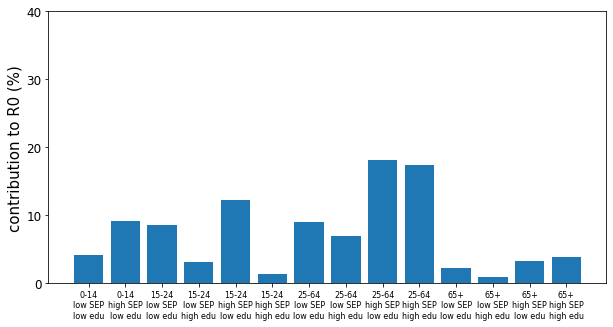

In [21]:
plt.figure(figsize=(10,5))

plt.bar(range(len(e)), 100*e)

plt.xticks(range(len(e)), 
           labels=[t.replace(', ', '\n') for t in M.index], fontsize=8)

plt.ylabel("contribution to R0 (%)", fontsize=15)

plt.yticks(np.arange(0,50,10), 
           labels = np.arange(0,50,10), fontsize=12)

plt.show()

# compute cumulative elasticities for each matrix

In [42]:
save_output = pd.DataFrame()

for comb in range(1000):
    
    M = generate_matrix(comb)

    K = compute_next_gen_matrix_SIR(M)

    beta = compute_beta(M)

    # Compute eigenvalues and right eigenvectors
    eigenvalues, right_eigenvectors = np.linalg.eig(beta*K)
    # Find the index of the dominant eigenvalue 
    dominant_index = np.argmax(eigenvalues)
    # Extract dominant right eigenvectors
    dominant_right_eigenvector = right_eigenvectors[:,dominant_index]

    # Compute eigenvalues and left eigenvectors (eigenvectors of the transpose)
    eigenvalues, left_eigenvectors = np.linalg.eig(beta*K.T)
    # Find the index of the dominant eigenvalue 
    dominant_index = np.argmax(eigenvalues)
    # Extract dominant left eigenvectors
    dominant_left_eigenvector = left_eigenvectors[:,dominant_index]

    v = dominant_left_eigenvector 
    w = dominant_right_eigenvector

    # normalize w so that sum(w)=1
    w = w/(sum(w))

    # rescale v so that <v,w>=1
    v = v/np.dot(v,w)
    
    ## compute sensitivities
    s = np.array([0. for j in range(len(v))])

    for j in range(len(s)):
        s[j] = np.sum([v[i]*w[j] for i in range(len(s))])

    ## compute elasticities
    e = np.array([0. for j in range(len(v))])

    for j in range(len(v)):
        e[j] = np.sum([beta*K[i,j]*v[i]*w[j]/R0 for i in range(len(s))])
      
    dict_res = dict(zip(M.index, e))
    
    dict_res['comb'] = comb

    save_output = pd.concat((save_output, pd.DataFrame(dict_res, index=[comb])))  
    
    print(comb)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [43]:
save_output.head()

,"0-14, low SEP, low edu","0-14, high SEP, low edu","15-24, low SEP, low edu","15-24, low SEP, high edu","15-24, high SEP, low edu","15-24, high SEP, high edu","25-64, low SEP, low edu","25-64, low SEP, high edu","25-64, high SEP, low edu","25-64, high SEP, high edu","65+, low SEP, low edu","65+, low SEP, high edu","65+, high SEP, low edu","65+, high SEP, high edu",comb
0,0.041898,0.091603,0.087964,0.025026,0.125498,0.011208,0.090334,0.069168,0.181086,0.176435,0.024146,0.008581,0.034824,0.032230,0
1,0.041430,0.091760,0.105695,0.020057,0.111101,0.014200,0.093690,0.077131,0.160924,0.184202,0.022171,0.009800,0.034349,0.033489,1
2,0.044267,0.088657,0.092808,0.025686,0.115473,0.016570,0.098106,0.071715,0.173954,0.171279,0.020247,0.008939,0.034445,0.037853,2
3,0.044112,0.089101,0.090765,0.024250,0.122721,0.011082,0.091588,0.083640,0.170559,0.171793,0.020034,0.008977,0.036254,0.035121,3
4,0.044940,0.087721,0.101693,0.026822,0.114984,0.010539,0.091171,0.067790,0.177638,0.176263,0.020710,0.010663,0.034286,0.034782,4


In [44]:
save_output.to_csv("./../output/epidemic_output/output_R0contributions_susc_children{}.csv".format(susc_children), 
                   index=False)

# plot results

In [22]:
order_groups = ['0-14, low SEP, low edu', 
                '0-14, high SEP, low edu',
                '15-24, low SEP, low edu', 
                '15-24, low SEP, high edu',
                '15-24, high SEP, low edu', 
                '15-24, high SEP, high edu',
                '25-64, low SEP, low edu', 
                '25-64, low SEP, high edu',
                '25-64, high SEP, low edu', 
                '25-64, high SEP, high edu',
                '65+, low SEP, low edu', 
                '65+, low SEP, high edu',
                '65+, high SEP, low edu', 
                '65+, high SEP, high edu']

light_red = "#C58080"
light_blue = "#8080C5"
dark_red = "#8B0000"
dark_blue = "#00118B"

cols = dict(zip(order_groups, [light_red, light_blue, 
                          light_red, dark_red,
                          light_blue, dark_blue, 
                          light_red, dark_red,
                          light_blue, dark_blue, 
                          light_red, dark_red,
                          light_blue, dark_blue] ))

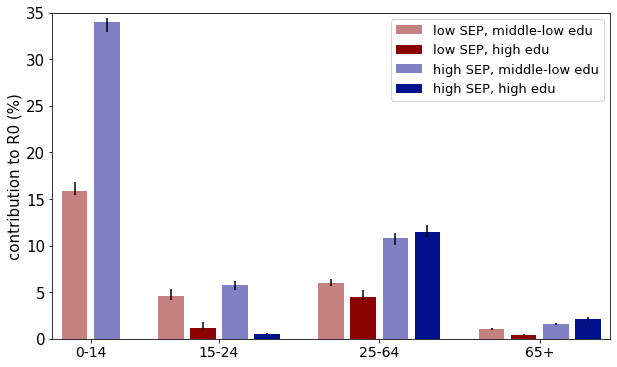

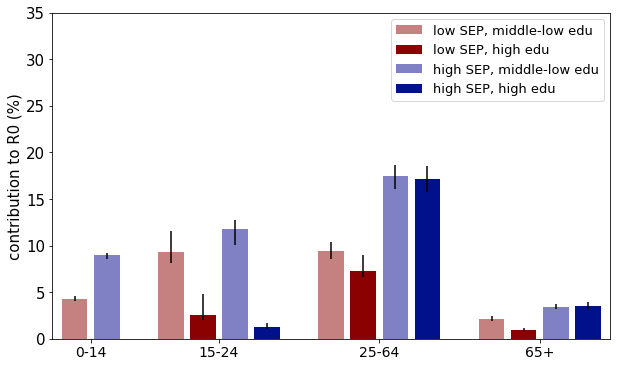

In [28]:
for susc_children in [1.0, 0.5]:
    
    save_output = pd.read_csv("./../output/epidemic_output/output_R0contributions_susc_children{}.csv".format(susc_children))
    
    plt.figure(figsize=(10,6)) 

    plt.bar([0], [0], color=light_red, label = 'low SEP, middle-low edu')
    plt.bar([0], [0], color=dark_red, label = 'low SEP, high edu')
    plt.bar([0], [0], color=light_blue, label = 'high SEP, middle-low edu')
    plt.bar([0], [0], color=dark_blue , label = 'high SEP, high edu')

    plt.legend(fontsize=13, bbox_to_anchor=(1,1), loc="upper right")

    e = 100*save_output[order_groups].median().values

    shift = 0
    for g in range(len(e)):
        if g in [2, 6, 10]:
            shift = shift +1 
        plt.bar(g+shift, e[g], color = cols[order_groups[g]]) #color = "#006E90")
        plt.vlines(g+shift, 100*save_output[save_output.columns[g]].quantile(0.025),
                      100*save_output[save_output.columns[g]].quantile(0.975),
                  color="black") 

    #plt.xticks(range(len(e)), 
    #           labels=[t.replace(', ', '\n') for t in M.index], fontsize=8)
    
    plt.ylabel("contribution to R0 (%)", fontsize=15)

    plt.yticks(np.arange(0,40,5), 
               labels = np.arange(0,40,5), fontsize=15)

    #if susc_children == 1.0:
    #    plt.title('homogeneous susceptibility accross socio-demographic groups\n', fontsize=15)
    #elif susc_children == 0.5:
    #    plt.title('50% reduction in susceptibility for 0-14 y.o.\n', fontsize=15)
    #else:
    #    sys.exit()

    plt.xticks([0.5,4.5,9.5,14.5], fontsize=14, 
               labels = ['0-14', '15-24', '25-64', '65+'])
    plt.xlim([-0.7, 16.7])
    
    plt.ylim([0,35.])
    
    plt.savefig("./../output/figures/contribution_to_R0_susc_children{}.png".format(susc_children), 
                dpi=200, bbox_inches="tight")

    plt.show()

# compute cumulative contacts

In [64]:
save_output = pd.DataFrame()

for comb in range(1000):
    
    M = generate_matrix(comb)
    
    dict_res = {}

    for i in M.index:
        num = sum([M.loc[i][j]*dict_pop_full[i] for j in M.columns])
        den = sum([sum([M.loc[h][j]*dict_pop_full[h] for j in M.columns]) for h in M.index])
        dict_res[i] = num/den
    
    dict_res['comb'] = comb

    save_output = pd.concat((save_output, pd.DataFrame(dict_res, index=[comb])))  
    
    print(comb)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [73]:
save_output.to_csv("./../output/epidemic_output/output_cumul_contacts.csv", index=False)

In [72]:
save_output.head()

,"0-14, low SEP, low edu","0-14, high SEP, low edu","15-24, low SEP, low edu","15-24, low SEP, high edu","15-24, high SEP, low edu","15-24, high SEP, high edu","25-64, low SEP, low edu","25-64, low SEP, high edu","25-64, high SEP, low edu","25-64, high SEP, high edu","65+, low SEP, low edu","65+, low SEP, high edu","65+, high SEP, low edu","65+, high SEP, high edu",comb
0,0.070438,0.153635,0.041993,0.006589,0.071782,0.00679,0.095878,0.062906,0.180565,0.175191,0.032726,0.009732,0.055804,0.035973,0
1,0.070438,0.153635,0.041993,0.006589,0.071782,0.00679,0.095878,0.062906,0.180565,0.175191,0.032726,0.009732,0.055804,0.035973,1
2,0.070438,0.153635,0.041993,0.006589,0.071782,0.00679,0.095878,0.062906,0.180565,0.175191,0.032726,0.009732,0.055804,0.035973,2
3,0.070438,0.153635,0.041993,0.006589,0.071782,0.00679,0.095878,0.062906,0.180565,0.175191,0.032726,0.009732,0.055804,0.035973,3
4,0.070438,0.153635,0.041993,0.006589,0.071782,0.00679,0.095878,0.062906,0.180565,0.175191,0.032726,0.009732,0.055804,0.035973,4


**this quantity is the same for all the matrices because we set the sum of the rows to be equal to the intermediate matrices, by construction**

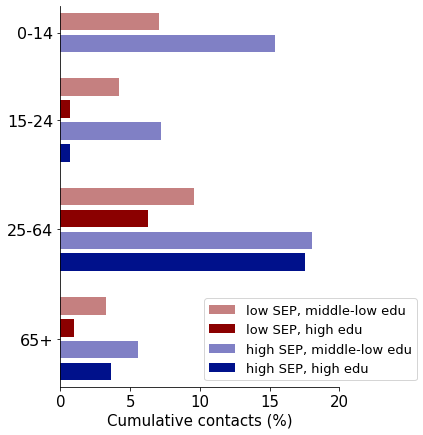

In [29]:
save_output = pd.read_csv("./../output/epidemic_output/output_cumul_contacts.csv")

plt.figure(figsize=(5, 7))  # Adjust the figure size for vertical orientation

# Legend bars
plt.barh([0], [0], color=light_red, label='low SEP, middle-low edu')
plt.barh([0], [0], color=dark_red, label='low SEP, high edu')
plt.barh([0], [0], color=light_blue, label='high SEP, middle-low edu')
plt.barh([0], [0], color=dark_blue, label='high SEP, high edu')

plt.legend(fontsize=13, bbox_to_anchor=(1.3, 0), loc="lower right")

e = 100 * save_output[order_groups].median().values

shift = 0
for g in range(len(e)):
    if g in [2, 6, 10]:
        shift = shift + 1
    plt.barh(g + shift, e[g], color=cols[order_groups[g]])

plt.yticks([0.5, 4.5, 9.5, 14.5], labels=['0-14', '15-24', '25-64', '65+'], fontsize=16)
plt.ylim([-0.7, 16.7])

plt.xlabel("Cumulative contacts (%)", fontsize=15)
plt.xticks(np.arange(0, 45, 5), labels=np.arange(0, 45, 5), fontsize=15)
plt.xlim([0., 20.])

# Invert the y-axis
plt.gca().invert_yaxis()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.savefig("./../output/figures/contribution_to_average_contacts_vertical.png",
            dpi=200, bbox_inches="tight")

plt.show()